In [1]:
import numpy as np
a,b,c=np.array([0,2,6])
c



6

# Solving the Simple Pendulum Equation with Runge-Kutta and Burlisch-Stoer ODE integrators

We saw in the previous lecture that a straightforward integration of the pendulum equation was possible. More sophisticated solvers follow essentially the same idea, but calculate the "steps" more carefully. Here we will follow NR chapter 17 (which the following figures and equations are copied from).
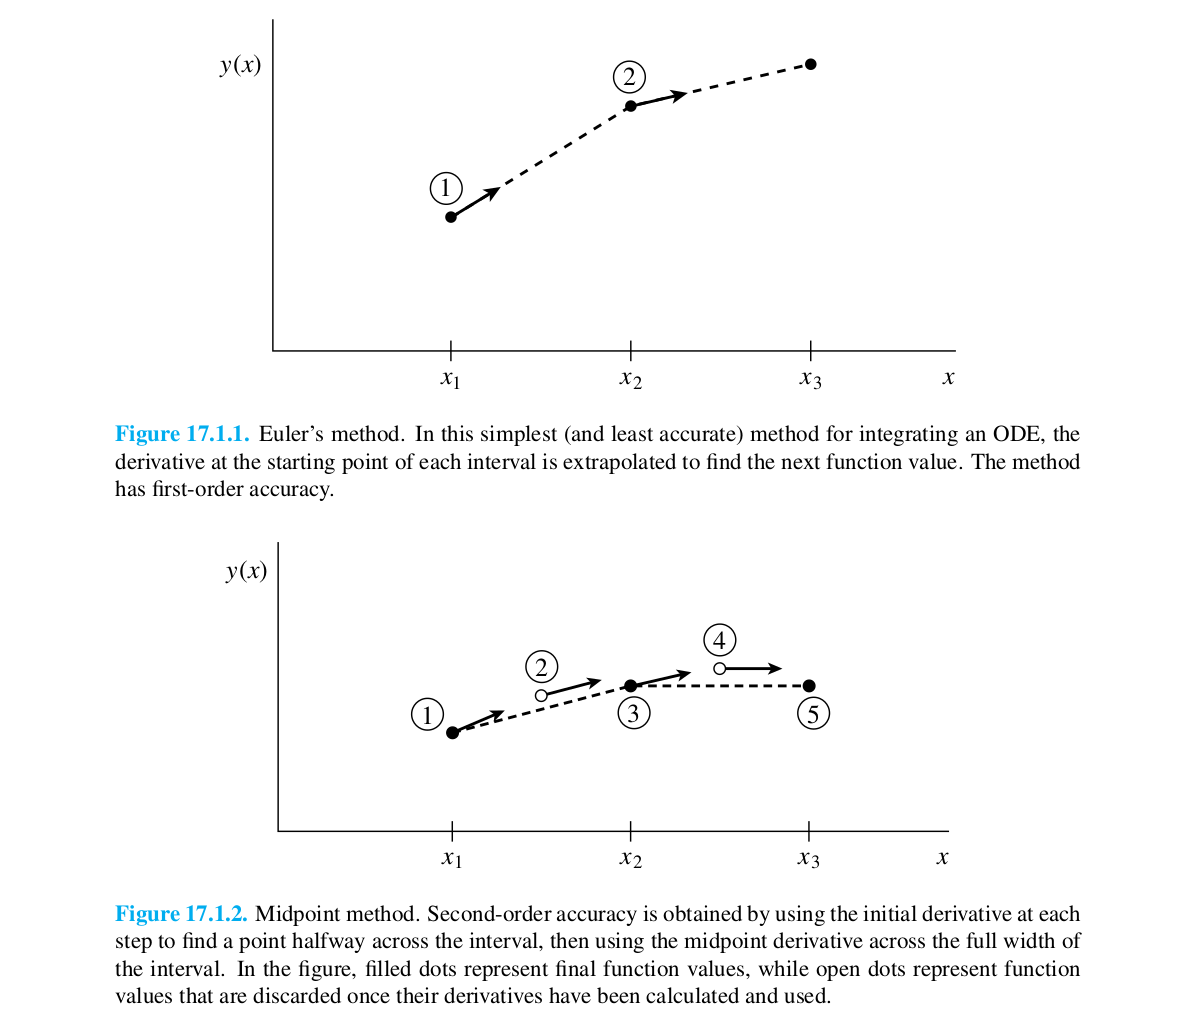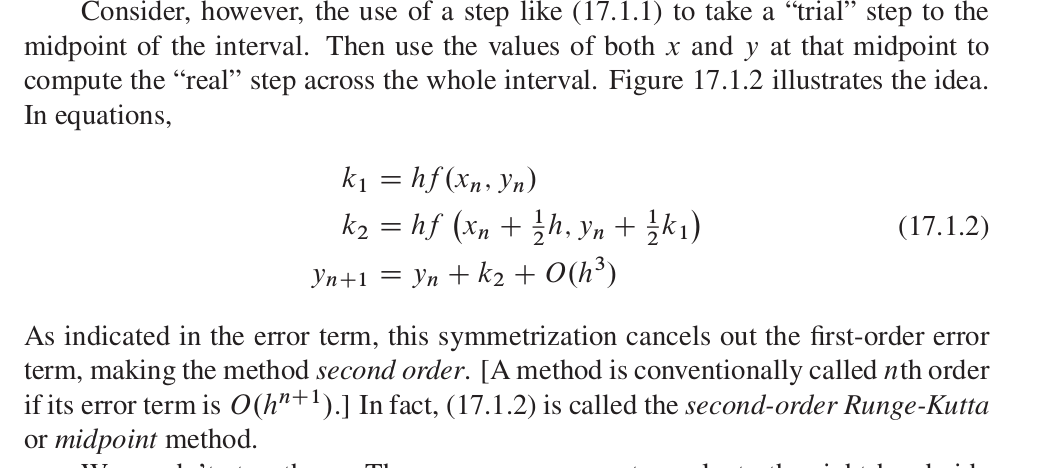
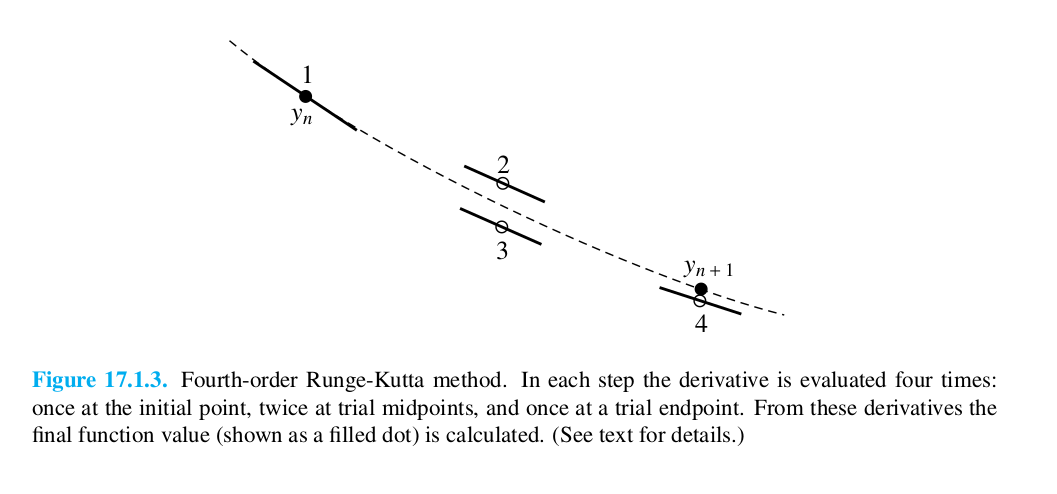
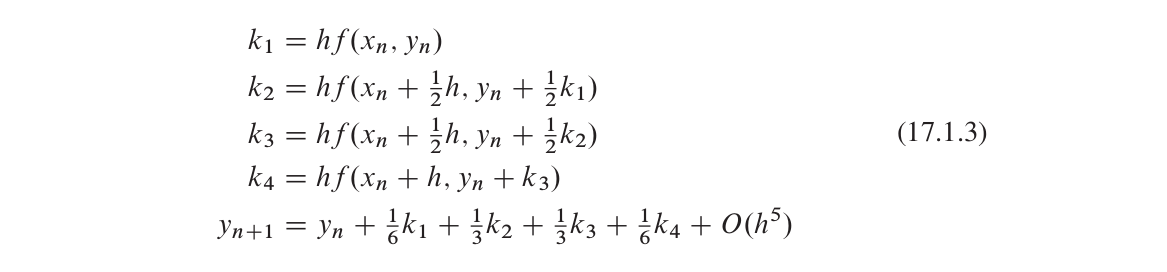

We also add **Adaptive Stepsize Control** so that one calculates the steps close together when the derivatives are large and far apart when they ware small:  

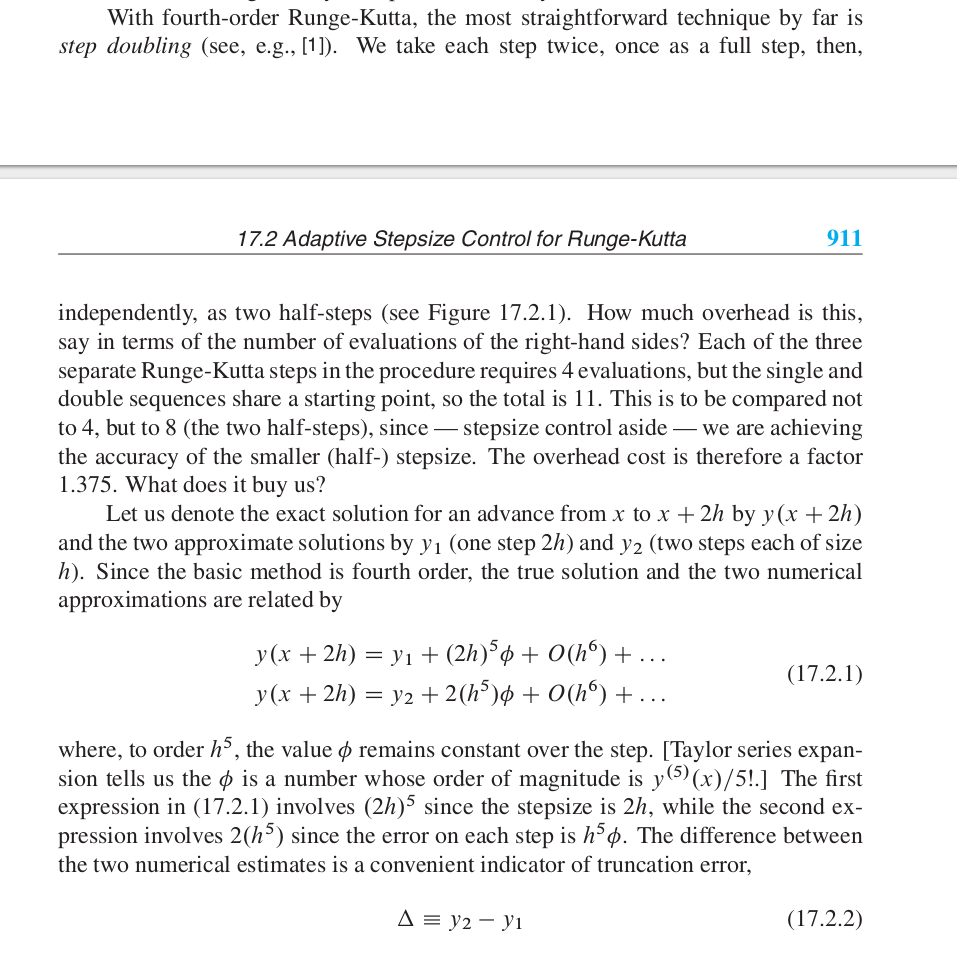

Following this general idea, people have come up with explicit formulas which maximize precision and allow you to calculate the function at fewer places.  Note, however, that all schemes work well for smooth functions- but Taylor series rely on derivatives being defined and continuous to work.  That is usually the case in Physics, but there are times (like when you use MC generated data) that functions are provided in an explicitly discrete form.  

NR also adds **Dense Output** (section 17.2.2) to the mix.  

NR recommends using the "Dormand Prince" embedded method DOPR853 as a generic ODE solver.  



We go back and now code the derivative as a function.   The inputs to the function is a np.array y:
\begin{equation}
\frac{dy}{dt}=\frac{d}{dt}\left(
\begin{array}{c}
y_1\\
y_0\\
\end{array}
\right)=
\frac{d}{dt}\left(
\begin{array}{c}
\omega\\
\theta\\
\end{array}
\right)=
\left(
\begin{array}{c}
-\frac{g}{l}\sin{\theta}\\
\omega\\
\end{array}\right)
\end{equation}

neval= 6248


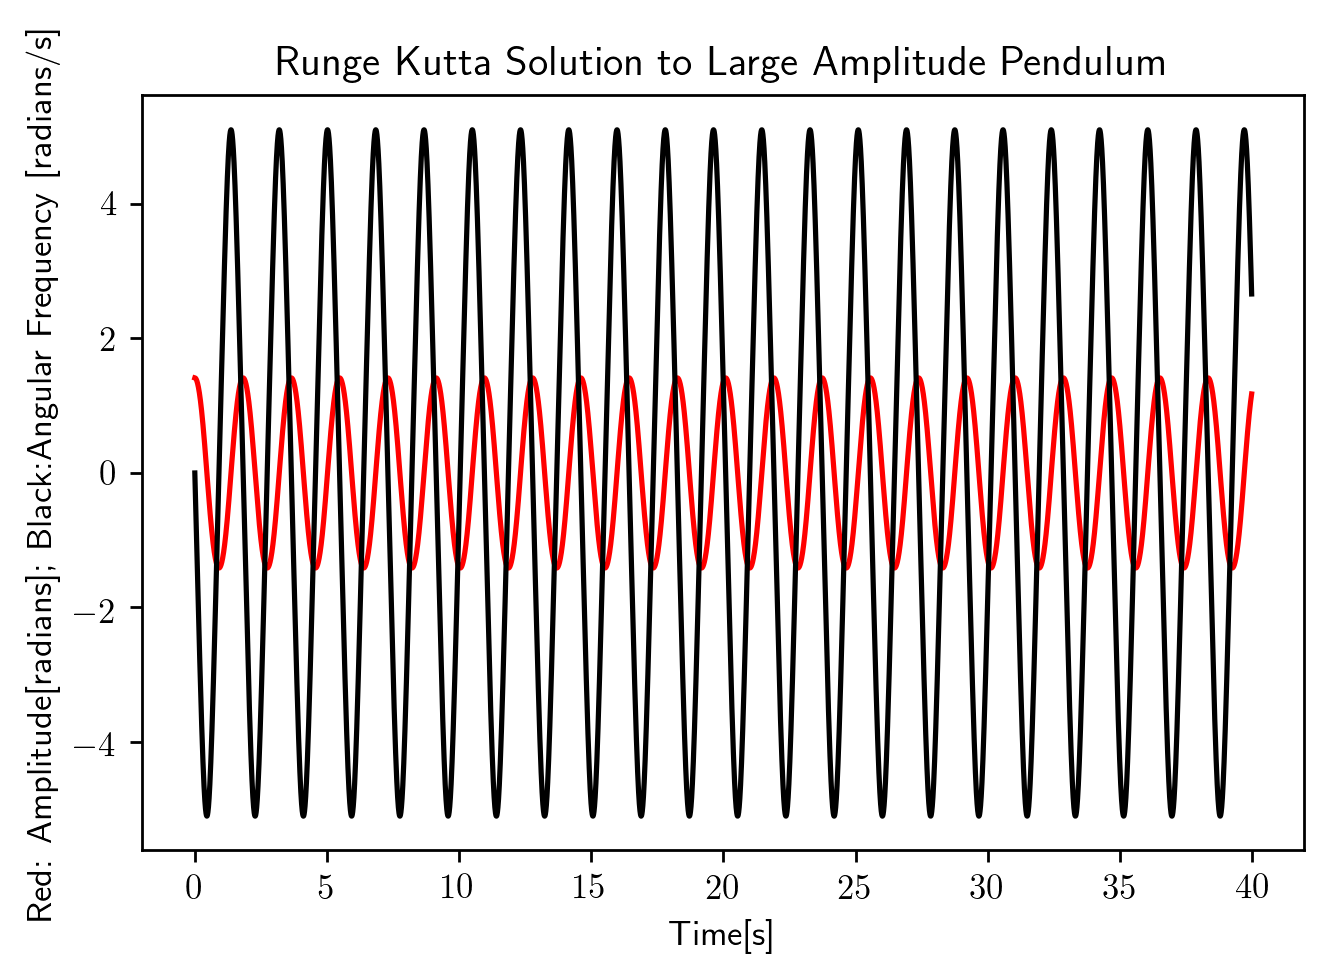

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)
mpl.rc('text',usetex=True)

from scipy.integrate import odeint

neval=0

def pend(y,t):
    global neval
    theta, omega = y
    dydt = np.array([omega, - g/l*np.sin(theta)])
    neval=neval+1
    return dydt

#and now we set up some constants (measured quantities)
l=0.635 #length of pendulum, meters
g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi*9/20.

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0])
    
#    We generate a solution 1001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:

t = np.linspace(0, 25*T, 10001)
    
###    Call `odeint` to generate the solution.  To pass the parameters
#    `b` and `c` to `pend`, we give them to `odeint` using the `args`
#    argument.
    
#solrk = odeint(pend, y0, t)
solrk = odeint(pend, y0, t,rtol=1e-11,atol=1e-11)
print('neval=',neval)
ifig=1
plt.figure(ifig)
ifig=ifig+1
plt.plot(t, solrk[:, 0], 'r', label='rk theta(t)')
plt.plot(t, solrk[:, 1], 'k', label='rk omega(t)')
plt.title("Runge Kutta Solution to Large Amplitude Pendulum")
plt.xlabel('Time[s]')
plt.ylabel('Red: Amplitude[radians]; Black:Angular Frequency [radians/s]')
#plt.legend(loc='best')
#plt.xlabel('t')
#plt.grid()
#plt.show()


In [5]:
help(odeint)

Help on function odeint in module scipy.integrate.odepack:

odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0, ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0, hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12, mxords=5, printmessg=0)
    Integrate a system of ordinary differential equations.
    
    Solve a system of ordinary differential equations using lsoda from the
    FORTRAN library odepack.
    
    Solves the initial value problem for stiff or non-stiff systems
    of first order ode-s::
    
        dy/dt = func(y, t0, ...)
    
    where y can be a vector.
    
    *Note*: The first two arguments of ``func(y, t0, ...)`` are in the
    opposite order of the arguments in the system definition function used
    by the `scipy.integrate.ode` class.
    
    Parameters
    ----------
    func : callable(y, t0, ...)
        Computes the derivative of y at t0.
    y0 : array
        Initial condition on y (can be a vector).
    t : array
        

Notice!  ~3500 evaluations- versus tens of millions.  

22 cycles instead of 25.  

Rerun with theta_0=9/20*np.pi


How well do we do when we check the derivative calculation?

Check this with different numbers of events in the output space.  Also notice that increasing the number of output points doesn't affect the number of evaluations.

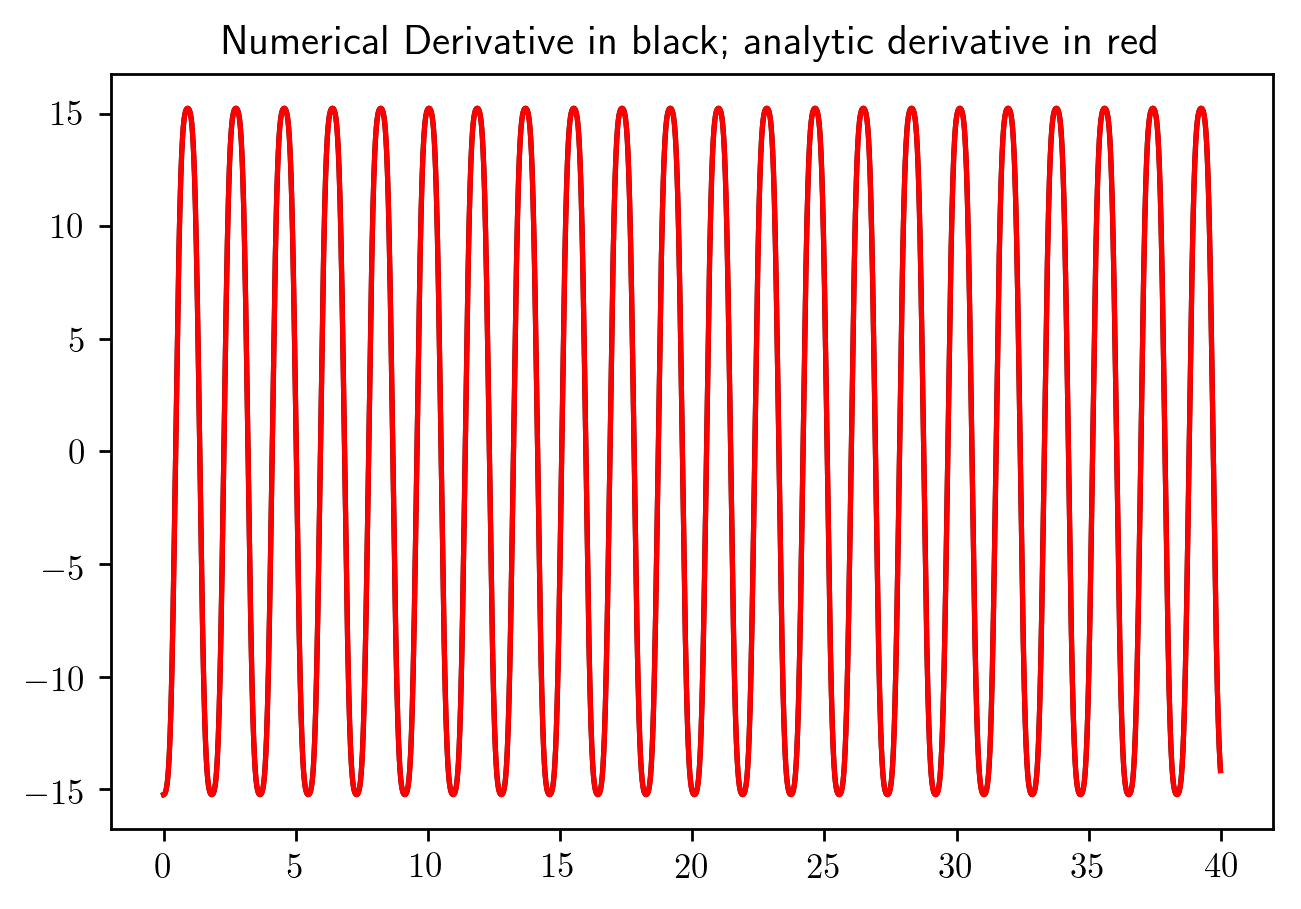

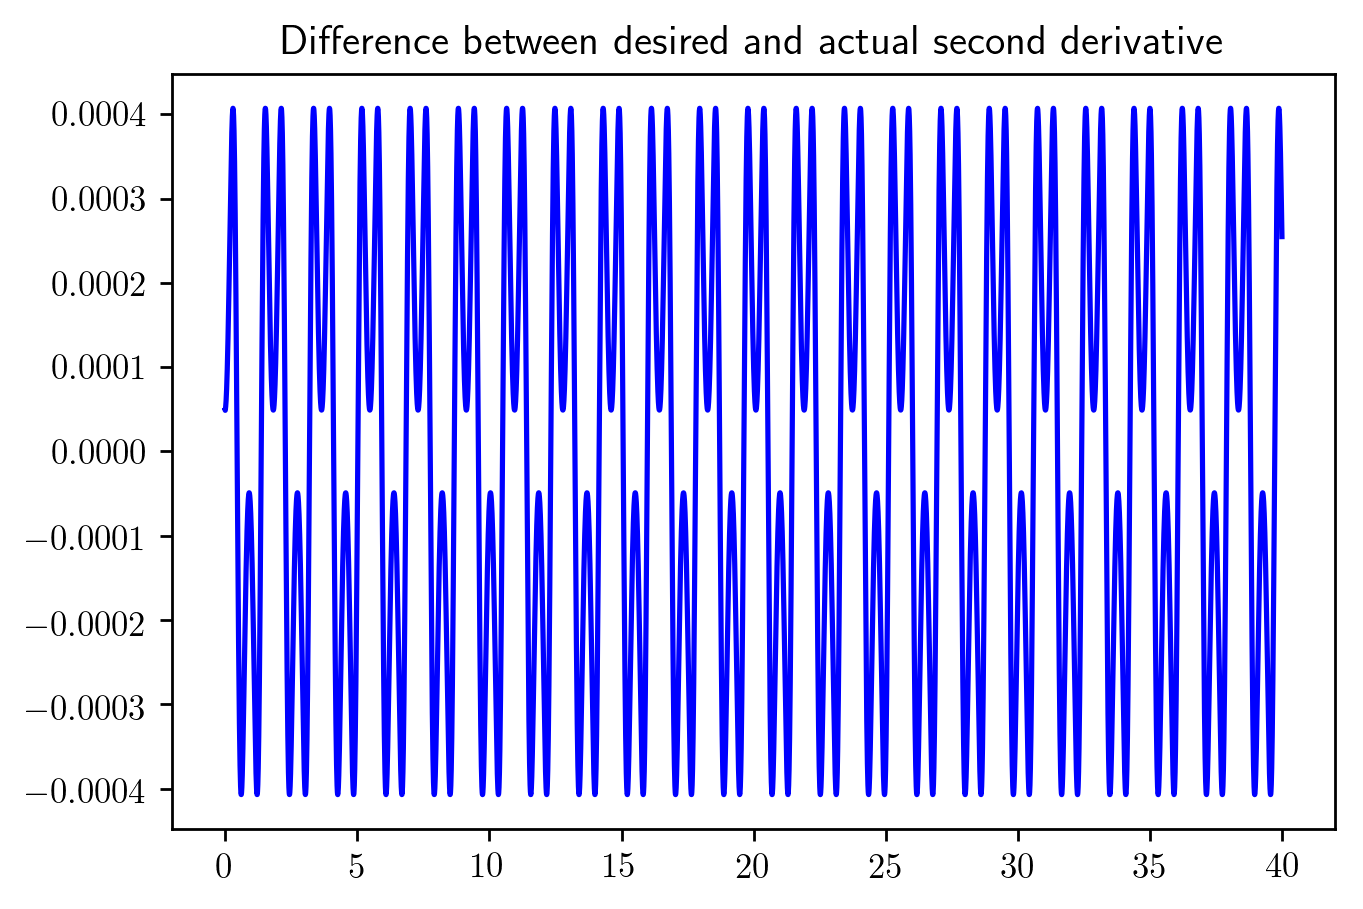

[ 1.41359484  1.4132293   1.41262007 ...,  1.14167259  1.15287953
  1.16386098]
[ 1.41371669  1.41359484  1.4132293  ...,  1.15287953  1.16386098
  1.17461584]


In [14]:
thetaOfT=solrk[1:-1,0]
thetaTPlusH=solrk[2:,0]
thetaTMinusH=solrk[:-2,0]
h=t[1]
factor=1
thetaDotDot=(1/h**2)*(thetaTPlusH+thetaTMinusH-2*thetaOfT)
plt.figure(ifig)
ifig=ifig+1
plt.plot(t[1:-1:factor],thetaDotDot[::factor],'k')
plt.plot(t[1:-1:factor],-g/l*np.sin(thetaOfT),'r')
plt.title("Numerical Derivative in black; analytic derivative in red")
plt.show()

plt.figure(ifig)
ifig=ifig+1
diff=thetaDotDot[::factor]+g/l*np.sin(thetaOfT)
plt.plot(t[1:-1:factor],diff,'b')
plt.title("Difference between desired and actual second derivative")
plt.show()

print(thetaOfT)
print(solrk[:,0])

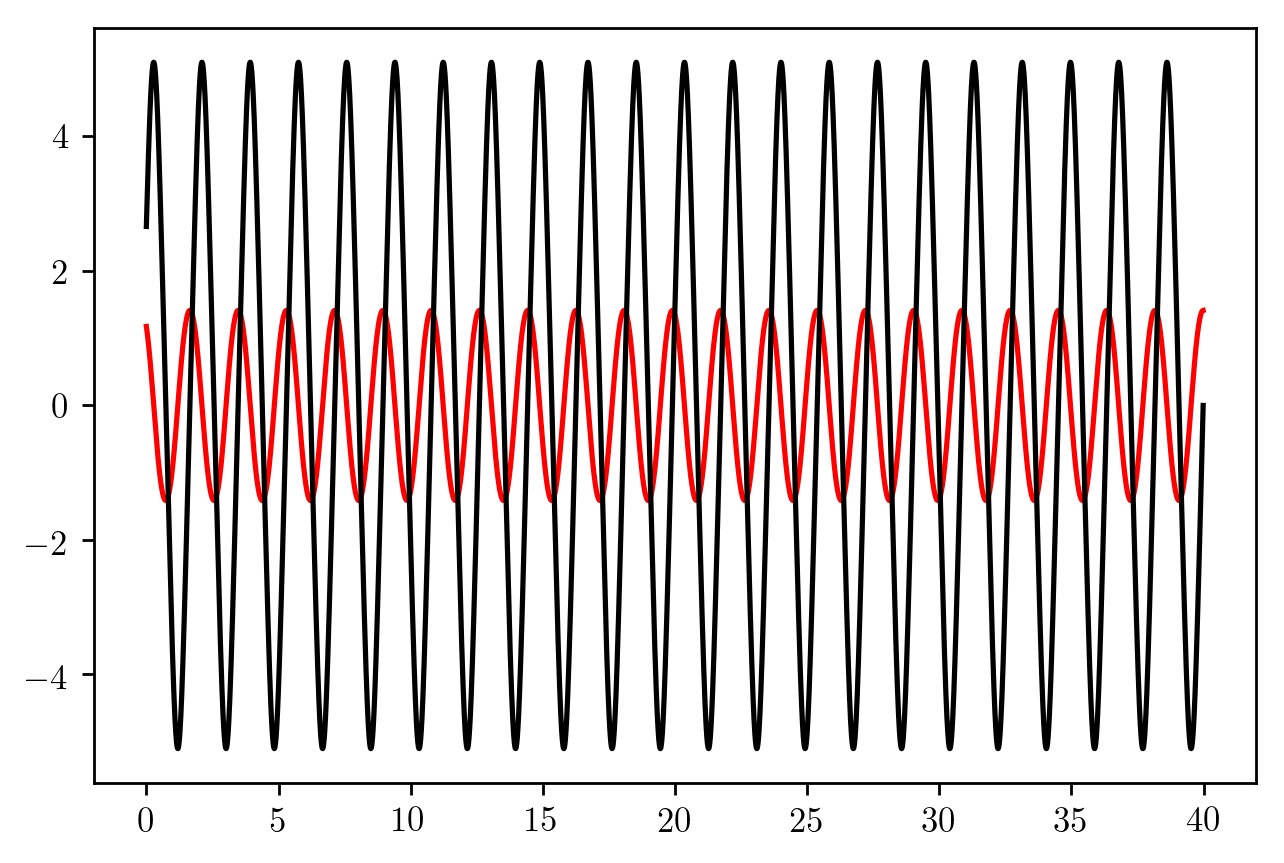

Final theta=1.413714 omega=0.000139
Original theta0=1.413717 omega0=0.000000
Fractional Difference= -1.52587395086e-08


In [16]:
y0=solrk[-1,:]  #initial condition is the final position of the forward motion

def pendReverse(y,t):
    return -pend(y,t)
rsolrk = odeint(pendReverse, y0, t)

plt.figure(ifig)
ifig=ifig+1
plt.plot(t, rsolrk[:, 0], 'r', label='rk theta(t)')
plt.plot(t, rsolrk[:, 1], 'k', label='rk omega(t)')
plt.show()

x=rsolrk
print('Final theta=%f omega=%f'%(x[-1,0],x[-1,1]))
print('Original theta0=%f omega0=%f'%(theta_0,0))
print('Fractional Difference=',(x[-1,0]-theta_0)/(50*np.pi))

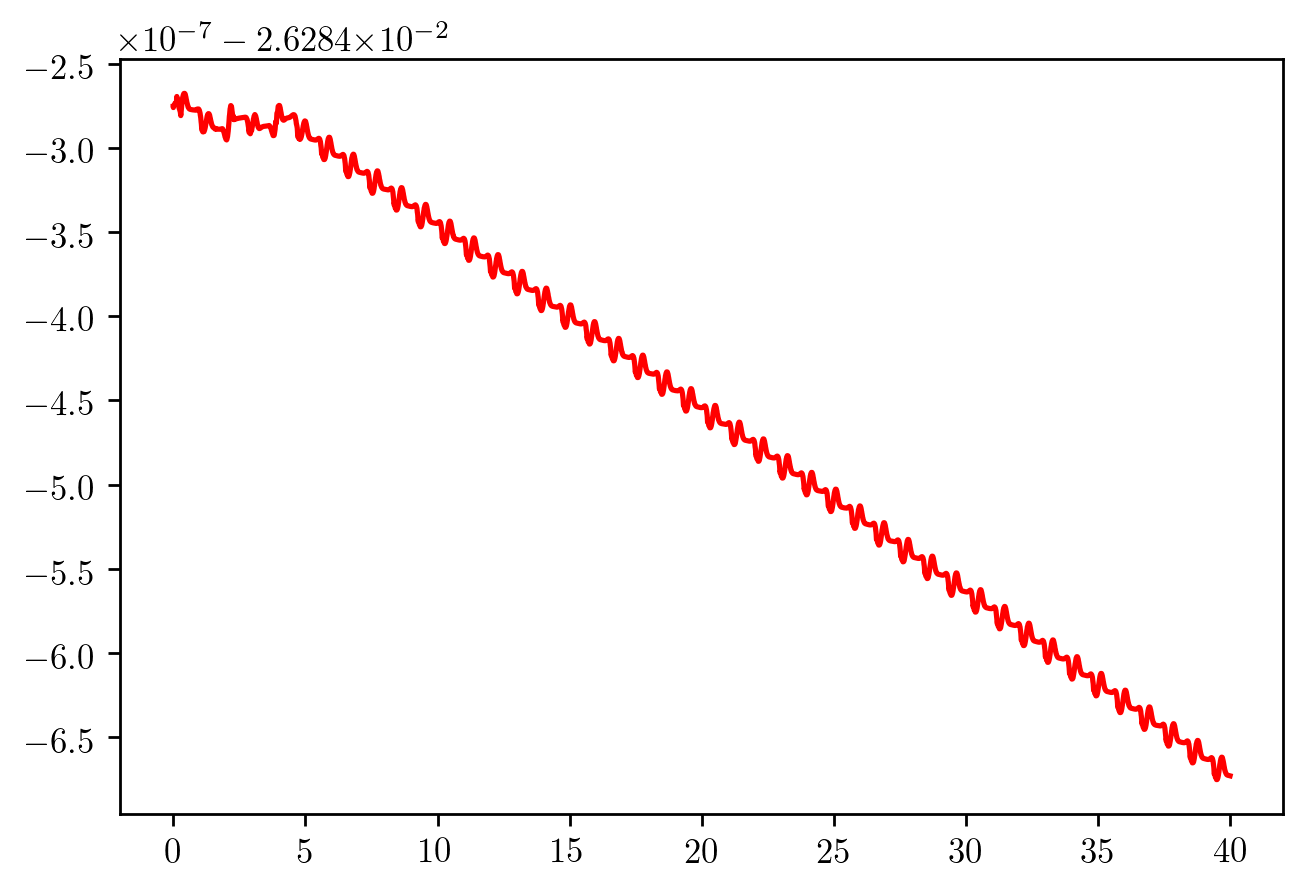

Energy is [-0.02628428 -0.02628428 -0.02628428 ..., -0.02628467 -0.02628467
 -0.02628467]


In [17]:
m=0.027
Energy=(0.5*m*l**2)*x[::factor,1]**2-(m*g*l)*np.cos(x[::factor,0])
plt.figure(ifig)
ifig+=1
plt.plot(t,Energy,'r')
plt.show()
print('Energy is', Energy)

Obviously, a **huge** increase in precision with a huge decrease in function evaluations.

# Bulirsch-Stoer Integration


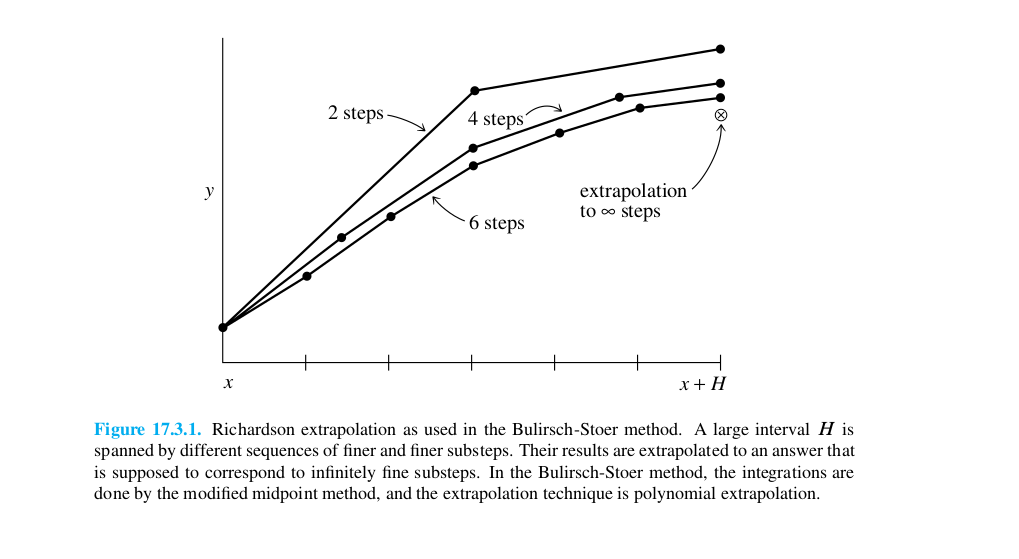

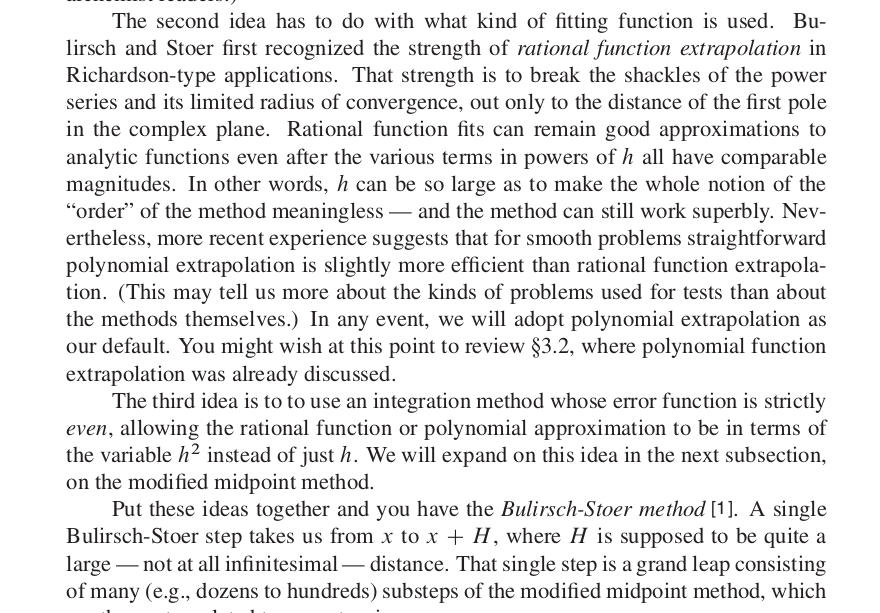

neval= 7228


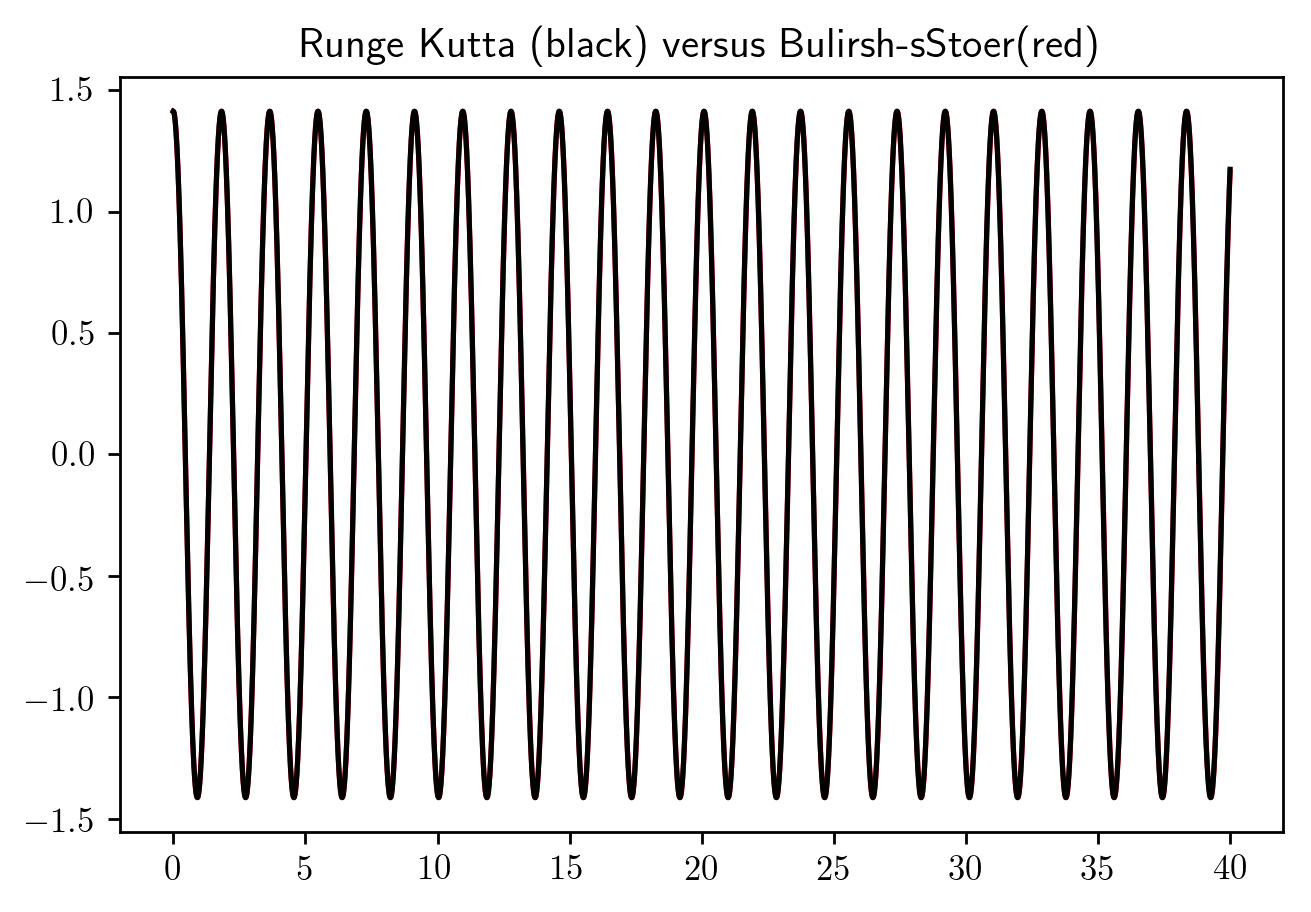

In [18]:
from nrODE import nrODE_BS

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0])
    
###    Call `odeint` to generate the solution.  To pass the parameters
#    `b` and `c` to `pend`, we give them to `odeint` using the `args`
#    argument.
t = np.linspace(0, 25*T, 10001)    
neval=0
solbs = nrODE_BS(pend, y0, t)
print('neval=',neval)

plt.figure(ifig)
plt.title("Runge Kutta (black) versus Bulirsh-sStoer(red)")
ifig=ifig+1
plt.plot(t, solbs[:, 0], 'r', label='bs theta(t)')
plt.plot(t, solrk[:, 0], 'k', label='rk theta(t)')

#plt.legend(loc='best')
#plt.xlabel('t')
#plt.grid()
plt.show()


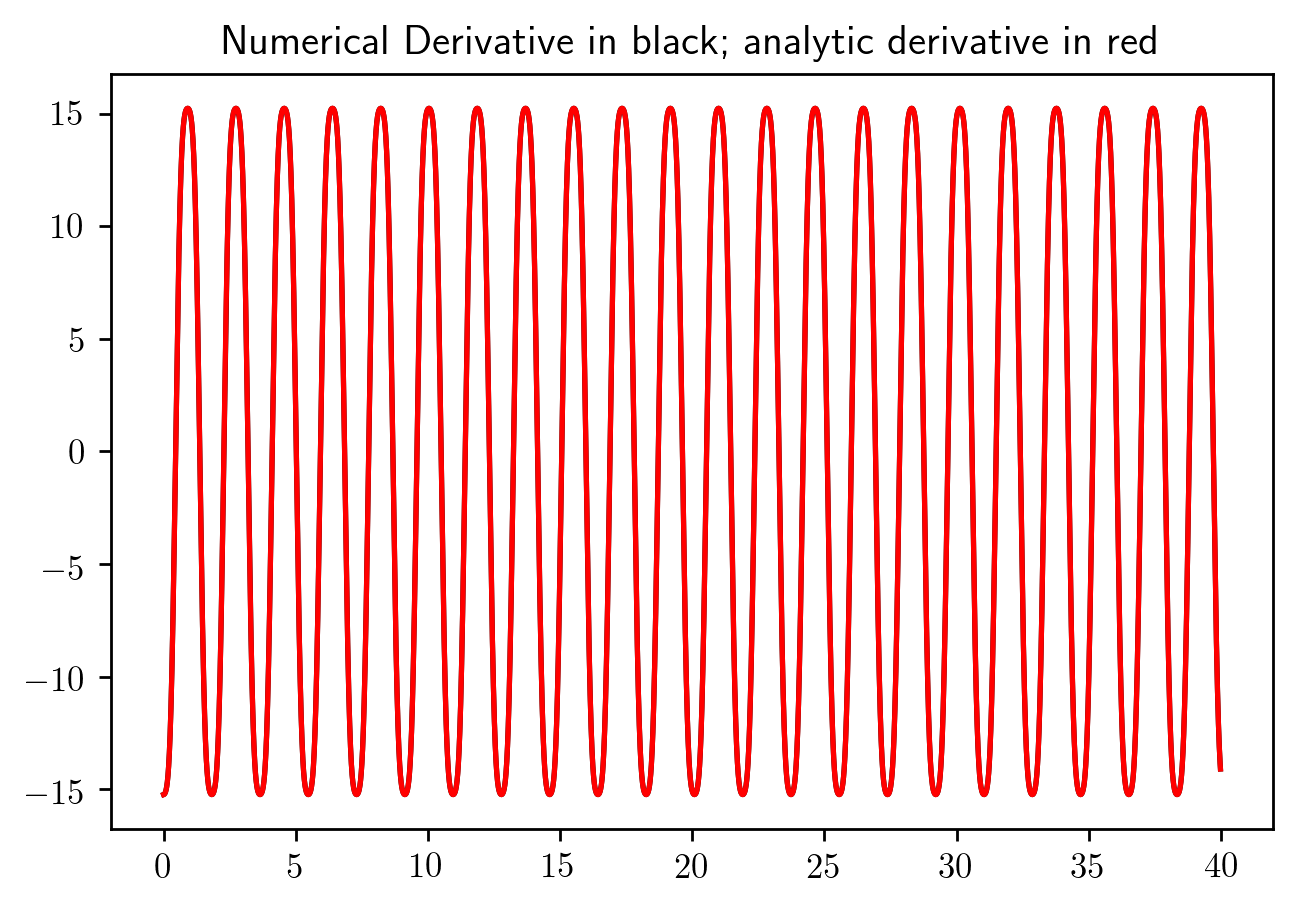

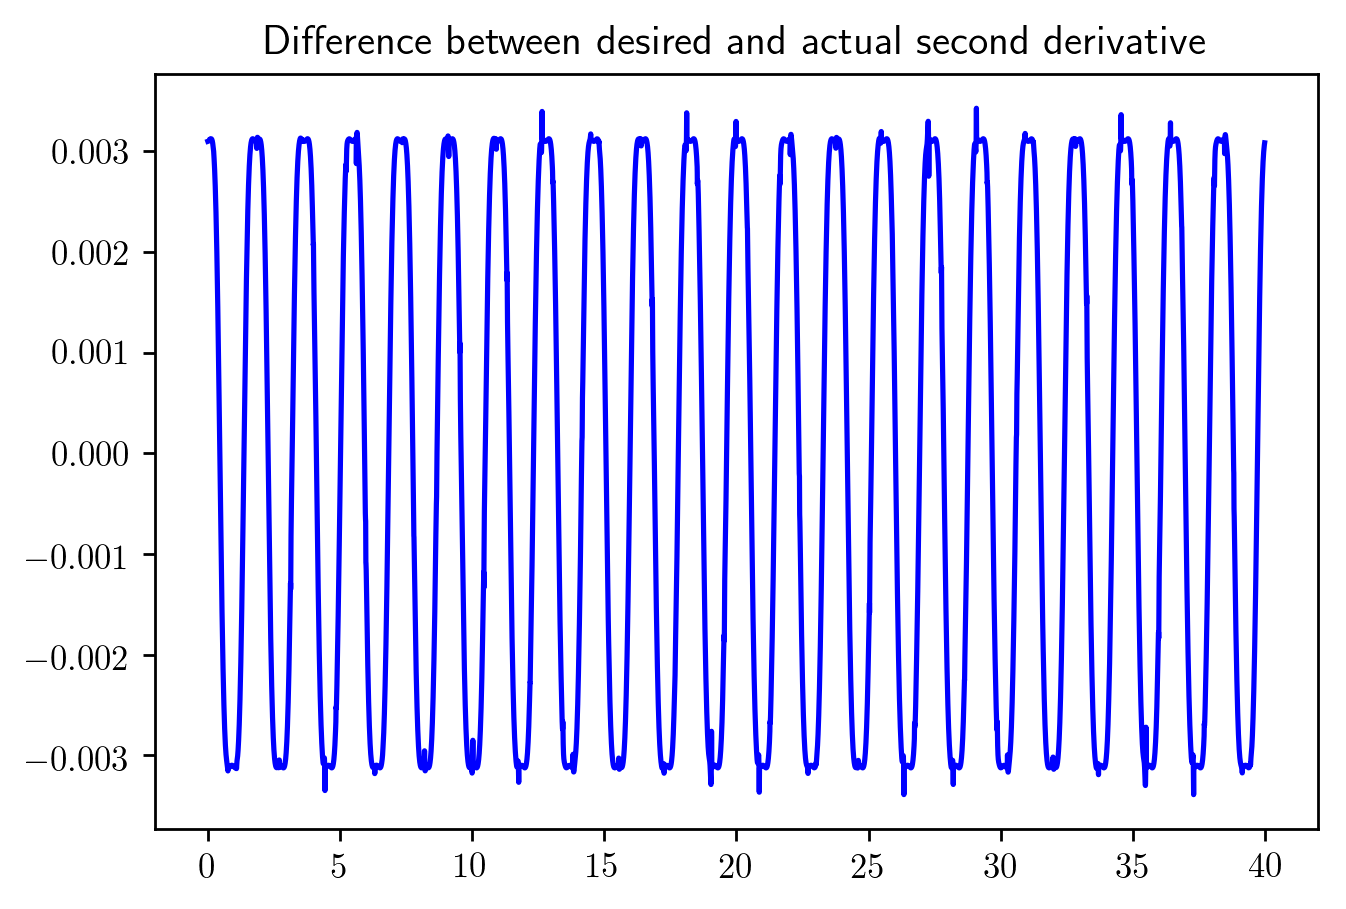

In [19]:
thetaOfT=solbs[1:-1,0]
thetaTPlusH=solbs[2:,0]
thetaTMinusH=solbs[:-2,0]
h=t[1]
factor=1
thetaDotDot=(1/h**2)*(thetaTPlusH+thetaTMinusH-2*thetaOfT)
plt.figure(ifig)
ifig=ifig+1
plt.plot(t[1:-1:factor],thetaDotDot[::factor],'k')
plt.plot(t[1:-1:factor],-g/l*np.sin(thetaOfT),'r')
plt.title("Numerical Derivative in black; analytic derivative in red")
plt.show()

plt.figure(ifig)
ifig=ifig+1

diff=thetaDotDot[::factor]+g/l*np.sin(thetaOfT)
plt.plot(t[1:-1:factor],diff,'b')
plt.title("Difference between desired and actual second derivative")
plt.show()


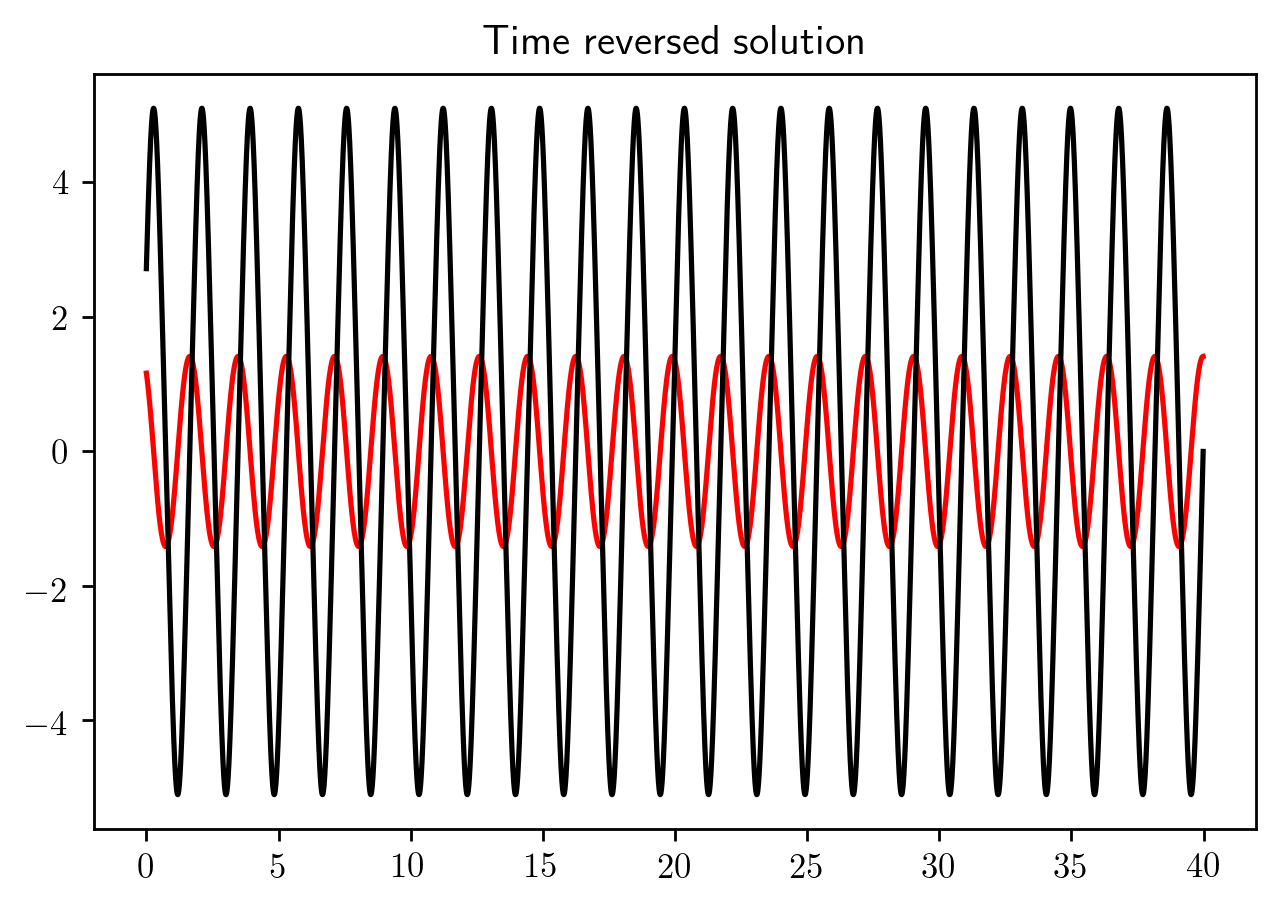

Final theta=1.413716 omega=0.000056
Original theta0=1.413717 omega0=0.000000
Fractional Difference= -6.2081311937e-09


In [20]:
y0=solbs[-1,:]  #initial condition is pendulum at rest

def pendReverse(y,t):
    return -pend(y,t)
rsolbs = nrODE_BS(pendReverse, y0, t)

plt.figure(ifig)
ifig=ifig+1
plt.title("Time reversed solution")
plt.plot(t, rsolbs[:, 0], 'r', label='bs theta(t)')
plt.plot(t, rsolbs[:, 1], 'k', label='bs omega(t)')
plt.show()

x=rsolbs
print('Final theta=%f omega=%f'%(x[-1,0],x[-1,1]))
print('Original theta0=%f omega0=%f'%(theta_0,0))
print('Fractional Difference=',(x[-1,0]-theta_0)/(50*np.pi))

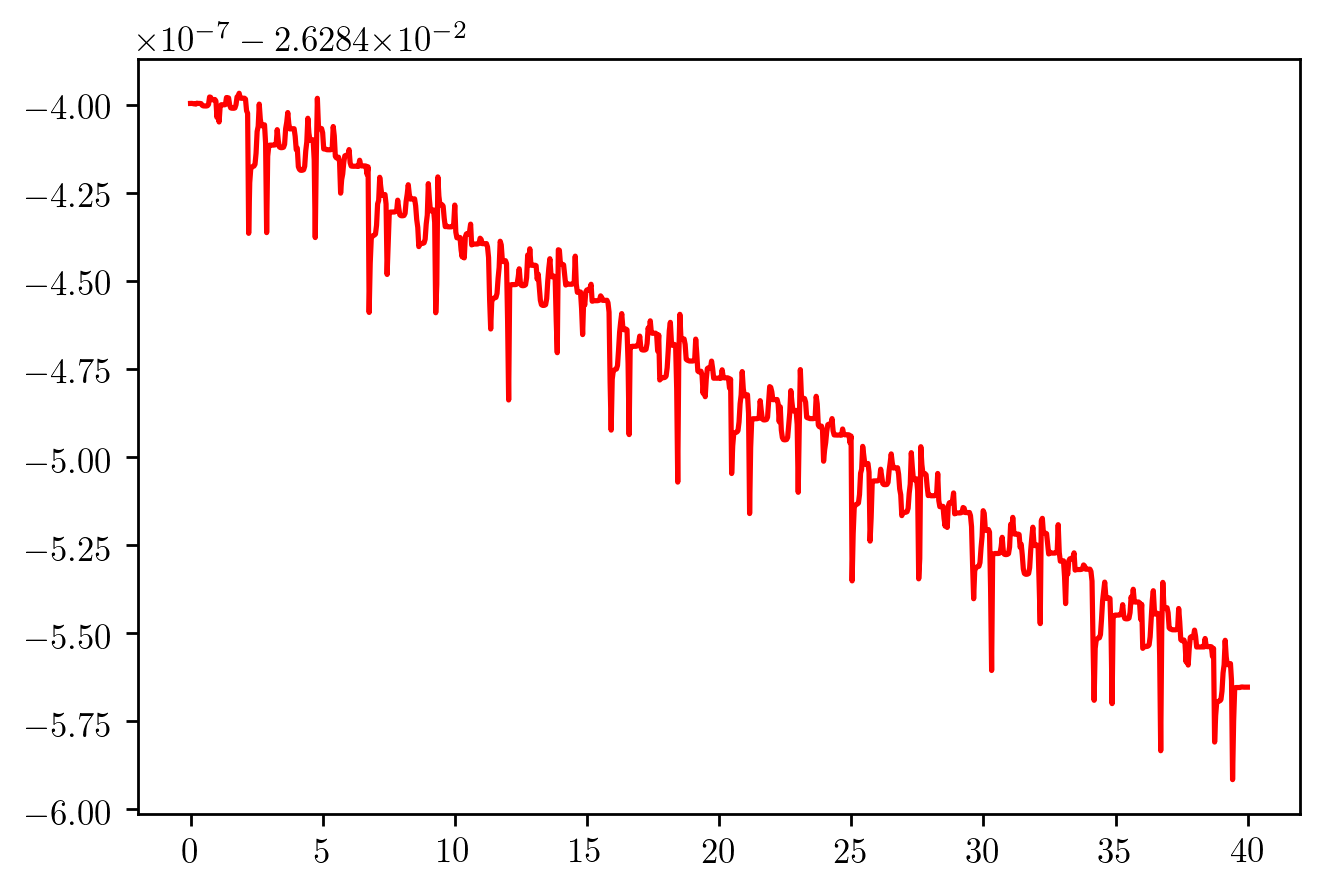

Energy is [-0.0262844  -0.0262844  -0.0262844  ..., -0.02628457 -0.02628457
 -0.02628457]


In [23]:
m=0.027
x=rsolbs  #do this because I just cut and paste the energy expression from Euler's method, where we used x.
Energy=(0.5*m*l**2)*x[::factor,1]**2-(m*g*l)*np.cos(x[::factor,0])
plt.figure(ifig)
ifig+=1
plt.plot(t,Energy,'r')
plt.show()
print('Energy is', Energy)

While Bulirsh Stoer is much better than Euler's method, it is clear that it does not perform as well as the Runge-Kutta integration. 

# Calling Numerical Recipes routines (or other packages not linked to python).

We probably won't need to do this much. But there are times when you may find it convenient- like here, where there was no Bulirsh-Stoer integration routine in numpy/scipy.  There are also licensing issues- NR, despite being written by faculty- has a much more restrictive license for running the code than typical. Here is the code (nrODE.cxx) that I called to run BS.  A compiled library (which works on cybera and is consistent with the license terms) and the source code is included in a zip file on eclass :

```
#include "nr3python.h"
#include "nr3.h"
#include "odeint.h"
#include "stepper.h"
#include "stepperbs.h"
#include "stepperdopr5.h"
#include "stepperdopr853.h"

//implement nrODE- which should follow the basic i/o structure of the scipy.odeint package

struct rhs{
  rhs(PyObject *aPyFunction){    
    func=aPyFunction;
    iscallable=PyCallable_Check(func);
    Py_XINCREF(func);
    params=NULL;
  }
  double *params;
  PyObject *func;
  bool iscallable;
  void operator() (const Doub x, VecDoub &y, VecDoub &dydx) {
    PyObject *argy=NRpyObject(y);
    PyObject *args=Py_BuildValue("(O,d)",argy,x);
    PyArrayObject *eval;
    PyObject *e=PyObject_CallObject(func,args);
    PyArray_OutputConverter(e,&eval);
    VecDoub retval(eval);
    dydx=retval;
  }
};


PyObject *nrODE(int i, PyObject *self, PyObject *pyargs){
  NRpyArgs args(pyargs); 
  rhs d(args[0]);  //Declare d as a rhs.
  PyArrayObject *a1,*a2;
  int i1=PyArray_OutputConverter(args[1],&a1);
  int i2=PyArray_OutputConverter(args[2],&a2);
  VecDoub y0(a1); // vector of initial conditions on y
  VecDoub t(a2); // vector of times points to which to solve for y.  
  //first entry of t is the inital time.
  int nvar=(int)y0.size();
  const Doub atol=1.0e-8, rtol=atol, h1=0.01, hmin=0.0;
  int nsteps=(int)t.size(); 
  Output out(nsteps);
  if(i==0){
    Odeint<StepperBS<rhs> > ode(y0,t[0],t[nsteps-1],atol,rtol,h1,hmin,out,d);
    ode.integrate();
  }else if(i==1){
    Odeint<StepperDopr5<rhs> >ode(y0,t[0],t[nsteps-1],atol,rtol,h1,hmin,out,d);
    ode.integrate();
  }else if(i==2){
    Odeint<StepperDopr853<rhs> >ode(y0,t[0],t[nsteps-1],atol,rtol,h1,hmin,out,d);
    ode.integrate();
  }
  MatDoub outTranspose(nsteps,nvar);
  for(int i=0;i<nsteps;i++)for(int j=0;j<nvar;j++)outTranspose[i][j]=out.ysave[j][i];
  PyObject *ret=NRpyObject(outTranspose);
  return(ret);
}

static PyObject *nrODE_BS(PyObject *self, PyObject *pyargs){
  return nrODE(0,self,pyargs); 
}

static PyObject *nrODE_DP5(PyObject *self, PyObject *pyargs){
  return nrODE(1,self,pyargs); 
}

static PyObject *nrODE_DP853(PyObject *self, PyObject *pyargs){
  return nrODE(2,self,pyargs); 
}

// standard boilerplate
static PyMethodDef nrODE_methods[] = {
    {"nrODE_BS",nrODE_BS,METH_VARARGS, "Bulirsch-Stoer Integrator.  It has the same call format as scipy.integrate.odeint.  "},
    {"nrODE_DP5",nrODE_DP5,METH_VARARGS, "nrODE_DP5 is a Dormand-Prince Runge-Kutta Integrator.  It has the same call format as scipy.integrate.odeint.  "},
    {"nrODE_DP853",nrODE_DP853,METH_VARARGS, "nr_ODE_DP853 is a Dormand-Prince Runge-Kutta Integrator.  It has the same call format as scipy.integrate.odeint.  "},
    {NULL, NULL, 0, NULL} 
};

static struct PyModuleDef nrODEModule={
  PyModuleDef_HEAD_INIT,
  "nrODE",
  NULL,
  -1,
  nrODE_methods
};

//PyMODINIT_FUNC PyInit_tutorial1(void);
PyMODINIT_FUNC PyInit_nrODE(void) {
   import_array();
  return PyModule_Create(&nrODEModule);
}
```

and the include file "nr3python.h"- which is largely from the nr site, but has been modified for python 3.  A caution-- this code has not been verified, except by its use in nrODE.cxx (which required me to step through and find both compile time and execution time bugs.  

```
/* nr3python.h */
// version 0.4
// This file is a versin of nr3.h with hooks that
// make it easy to intePrface to Python
// See http://www.nr.com/nr_python_tutorial.html
#ifndef _NR3_H_
#define _NR3_H_
#ifndef Py_PYTHON_H
#include "Python.h"
#endif
#ifndef Py_ARRAYOBJECT_H
#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
#include "numpy/arrayobject.h"
#endif

#define _CHECKBOUNDS_ 1
//#define _USESTDVECTOR_ 1
//#define _USENRERRORCLASS_ 1
#define _TURNONFPES_ 1

// all the system #include's we'll ever need
#include <fstream>
#include <cmath>
#include <complex>
#include <iostream>
#include <iomanip>
#include <vector>
#include <limits>
#include <stdlib.h>
#include <stdio.h>
#include <time.h>
#include <fcntl.h>
#include <string.h>
#include <ctype.h>

using namespace std;

// NaN: uncomment one of the following 3 methods of defining a global NaN
// you can test by verifying that (NaN != NaN) is true

static const double NaN = numeric_limits<double>::quiet_NaN();

//Uint proto_nan[2]={0xffffffff, 0x7fffffff};
//double NaN = *( double* )proto_nan;

//Doub NaN = sqrt(-1.);

// Python glue Part I starts here (Part II at end of file)

PyObject* NRpyException(const char *str, int die=1, int val=0) {
	PyErr_Format(PyExc_RuntimeError,str,val);
	PyErr_Print();
	if (die) Py_Exit(1);  // is there a way to avoid killing the interactive interpreter?
	return Py_None;
}

char NRpyMainName[] = "__main__";
PyObject* NRpyGetByName(char *name, char *dict = NULL) {
// get a PyObject from Python namespace (__main__ by default)
	if (dict == NULL) dict = NRpyMainName;
	PyObject* pymodule = PyImport_AddModule(dict);
	PyObject* dictobj = PyModule_GetDict(pymodule);
	PyObject* bb = PyDict_GetItemString(dictobj,name);
	if (! bb) NRpyException("Failed to fetch a Python object by name.");
	return bb;
}

struct NRpyArgs {
// make arguments from Python individually addressable by [] subscript
	PyObject* pyargs;
	NRpyArgs(PyObject* pyaargs) : pyargs(pyaargs) {}
	int size() {return PyTuple_Size(pyargs);}
	PyObject* operator[](int i) {
		if (i<PyTuple_Size(pyargs)) return PyTuple_GetItem(pyargs,i);
		// Returns a borrowed (unprotected) ref.  Args refs owned by calling routine.
		else NRpyException("Index out of range in NRpyArgs.");
		return Py_None;
	}
};

// explicitly construct scalars and strings from PyObjects or Python namespace

int NRpyIsNumber(PyObject* ob) {return (PyLong_Check(ob) || PyFloat_Check(ob));}

// type Long
int NRpyLong(PyObject* ob) {
	if (ob == Py_None) return 0;
	if (NRpyIsNumber(ob)) return PyLong_AsLong(ob); // casts ob to int
	else NRpyException("NRpyLong argument is not a number.");
	return 0;
}
int NRpyLong(char *name, char *dict = NULL) {
	return NRpyLong(NRpyGetByName(name,dict));
}

// type Doub
double NRpyDoub(PyObject* ob) {
	if (ob == Py_None) return NaN;
	else if (NRpyIsNumber(ob)) return PyFloat_AsDouble(ob); // casts ob to double
	else NRpyException("NRpyDoub argument is not a number.");
	return 0.;
}
double NRpyDoub(char *name, char *dict = NULL) {
	return NRpyDoub(NRpyGetByName(name,dict));
}

// type char* (string)
char* NRpyCharP(PyObject *ob) {
	if (PyUnicode_Check(ob)) return PyUnicode_AsUTF8(ob);
	else NRpyException("NRpyCharP argument is not a string.");
	return NULL;
}
char* NRpyCharP(char *name, char *dict = NULL) {
	return NRpyCharP(NRpyGetByName(name,dict));
}

// type encapsulated function pointer (note different syntax so that templating can work)
template<class T> void NRpyCFunction(T* &fptr, PyObject* ob) {
	if (! PyCapsule_CheckExact(ob)) NRpyException("NRpyCFunction arg is not a C++ function capsule.");
	fptr = (T*)PyCapsule_GetPointer(ob,NULL);
	return;
}

// wrapper class for Python List, implementing only simple operations
struct NRpyList {
	PyObject* p;
	int n;
	int isnew;
	NRpyList(int nn) : p(PyList_New(nn)), n(nn), isnew(1) {
		for (int i=0;i<nn;i++) {
			Py_INCREF(Py_None); // needed?
			PyList_SetItem(p,i,Py_None);
		}
		if (! PyList_Check(p)) NRpyException("NRpyList not successfully created.");
	}
	NRpyList(PyObject *pp) : p(pp), isnew(0) {
		if (p == NULL) p = Py_None;
		n = (PyList_Check(p) ? PyList_Size(p) : 0);
	}
	int size() {return n;}
	template <class T> int set(int i, T val) {
		int flag = PyList_SetItem(p, i, NRpyObject(val));
		return flag;
	}
	NRpyList operator[](int i) {
		if (i >= n || i < 0) NRpyException("NRpyList subscript out of range.");
		return NRpyList(PyList_GetItem(p,i));
		// Returns a borrowed (unprotected) ref, but assumes List is bound by calling routine.
	}
};

//was NRpyLong(NRpyList &list)

int NRpyLong(const NRpyList &list) { // cast list to integer value of its 1st element
	return NRpyLong(PyList_GetItem(list.p,0)); 
}
// ToDo: also make NRpyList constructors for NRvector and NRmatrix

// wrapper class for Python Dict
struct NRpyDict {
	PyObject* p;
	int isnew;
	NRpyDict() : p(PyDict_New()), isnew(1) {}
	NRpyDict(PyObject *pp) : p(pp), isnew(0) {
		if (! PyDict_Check(pp)) NRpyException("Argument not a dict in NRpyDict constructor.");
	}
	template <class T, class U> int set(T key, U val) {
		PyObject *thekey = NRpyObject(key), *theval = NRpyObject(val);
		int flag = PyDict_SetItem(p, thekey, theval);
		Py_DECREF(thekey); // because PyDict_SetItem INCREFs both key and val
		Py_DECREF(theval);
		return flag; // returns 0 for success, -1 for failure
	}
	template <class T> PyObject* get(const T key) {
		PyObject *thekey = NRpyObject(key), *theval;
		theval = PyDict_GetItem(p, thekey); // borrowed ref
		Py_DECREF(thekey);
		if (theval) return theval; // intended use is immediate conversion so borrowed ref is ok
		else return Py_None; // ditto, won't be decremented because won't be returned to Python
	}
};

// overloaded functions to turn anything into a PyObject (vector and matrix are in Part II below)

template<class T> PyObject* NRpyObject(T &a) {
// default applies to all function objects or other structs
	PyObject *thing = PyCapsule_New((void*)a,NULL,NULL);
	return thing;
}
PyObject* NRpyObject(const double a) {return PyFloat_FromDouble(a);}
PyObject* NRpyObject(const int a) {return PyLong_FromLong(a);}
PyObject* NRpyObject(const bool a) {return PyBool_FromLong(a);}
PyObject* NRpyObject(const char *a) {return PyUnicode_FromString(a);} // string is copied
PyObject* NRpyObject() {return Py_BuildValue("");} // Python None
PyObject* NRpyObject(NRpyList &a) {
	if (! a.isnew) Py_INCREF(a.p); // make a new reference to return (should happen rarely)
	return a.p;
}
PyObject* NRpyObject(NRpyDict &a) {
	if (! a.isnew) Py_INCREF(a.p); // make a new reference to return (should happen rarely)
	return a.p;
}
// NRpyObjects are generally return values.  Hence they pass clear title to ownership.
// If you create an NRpyObject and don't return it, you need to Py_DECREF it later.

// send an object into Python namespace (except for scalars, will become shared ref)
template <class T>
void NRpySend(T &a, char *name, char *dict=NULL) {
	if (dict == NULL) dict = NRpyMainName;
	PyObject* pymodule = PyImport_AddModule(dict);
	PyObject* dictobj = PyModule_GetDict(pymodule);
	PyObject* aa = NRpyObject(a);
	int ret = PyDict_SetItemString(dictobj, name, aa);
	if (ret) NRpyException("Failed to share an NR object with Python.");
	Py_XDECREF(aa); // because dictobj now has the responsibility
}

// templated check of a PyObject's type (used in initpyvec and initpymat below)
template <class T> inline int NRpyTypeOK(PyArrayObject *a) {return 0;}
template <> inline int NRpyTypeOK<double>(PyArrayObject *a) {return PyArray_ISFLOAT(a);}
template <> inline int NRpyTypeOK<long>(PyArrayObject *a) {return PyArray_ISINTEGER(a);}

// templated return a PyObject's type (used in NRpyObject on vector and matrix args)
template <class T> inline int NRpyDataType() {return NPY_LONG;}  //was INT
template <> inline int NRpyDataType<double>() {return NPY_DOUBLE;}
template <> inline int NRpyDataType<int>() {return NPY_LONG;}

// tempated cast a PyObject's type (used in NRpyPyFunction for return type)
template <class T>  T NRpyCast(PyObject *a) {return (T*)NULL; }
template <> double NRpyCast<double>(PyObject *a) {return NRpyDoub(a);}
template <> int NRpyCast<int>(PyObject *a) {return NRpyLong(a);}
template <> char* NRpyCast<char*>(PyObject *a) {return NRpyCharP(a);}

// end Python glue Part I  (see Part II at end of file)

// macro-like inline functions

template<class T>
inline T SQR(const T a) {return a*a;}

template<class T>
inline const T &MAX(const T &a, const T &b)
        {return b > a ? (b) : (a);}

inline float MAX(const double &a, const float &b)
        {return b > a ? (b) : float(a);}

inline float MAX(const float &a, const double &b)
        {return b > a ? float(b) : (a);}

template<class T>
inline const T &MIN(const T &a, const T &b)
        {return b < a ? (b) : (a);}

inline float MIN(const double &a, const float &b)
        {return b < a ? (b) : float(a);}

inline float MIN(const float &a, const double &b)
        {return b < a ? float(b) : (a);}

template<class T>
inline T SIGN(const T &a, const T &b)
	{return b >= 0 ? (a >= 0 ? a : -a) : (a >= 0 ? -a : a);}

inline float SIGN(const float &a, const double &b)
	{return b >= 0 ? (a >= 0 ? a : -a) : (a >= 0 ? -a : a);}

inline float SIGN(const double &a, const float &b)
	{return (float)(b >= 0 ? (a >= 0 ? a : -a) : (a >= 0 ? -a : a));}

template<class T>
inline void SWAP(T &a, T &b)
	{T dum=a; a=b; b=dum;}

// exception handling

#ifndef _USENRERRORCLASS_
#define throw(message) \
{printf("ERROR: %s\n     in file %s at line %d\n", message,__FILE__,__LINE__); throw(1);}
#else
struct NRerror {
	char *message;
	char *file;
	int line;
	NRerror(char *m, char *f, int l) : message(m), file(f), line(l) {}
};
#define throw(message) throw(NRerror(message,__FILE__,__LINE__));
void NRcatch(NRerror err) {
	printf("ERROR: %s\n     in file %s at line %d\n",
		err.message, err.file, err.line);
	exit(1);
}
#endif

// usage example:
//
//	try {
//		somebadroutine();
//	}
//	catch(NRerror s) {NRcatch(s);}
//
// (You can of course substitute any other catch body for NRcatch(s).)


// Vector and Matrix Classes

#ifdef _USESTDVECTOR_
#define NRvector vector
#else

template <class T>
class NRvector {
private:
	int nn;	// size of array. upper index is nn-1
	T *v;
public:
	int ownsdata; // 1 for normal NRmatrix, 0 if Python owns the data
	PyArrayObject *pyident; // if I don't own my data, who does?
	NRvector();
	explicit NRvector(int n);		// Zero-based array
	NRvector(PyArrayObject *a);			// construct from Python array
	NRvector(char *name, char *dict = NULL); // construct from name in Python scope
	void initpyvec(PyArrayObject *a); // helper function used by above
	NRvector(int n, const T &a);	//initialize to constant value
	NRvector(int n, const T *a);	// Initialize to array
	NRvector(const NRvector &rhs);	// Copy constructor
	NRvector & operator=(const NRvector &rhs);	//assignment
	typedef T value_type; // make T available externally
	inline T & operator[](const int i);	//i'th element
	inline const T & operator[](const int i) const;
	inline int size() const;
	void resize(int newn); // resize (contents not preserved)
	void assign(int newn, const T &a); // resize and assign a constant value
	void assign(char *name, char *dict = NULL); // assign to a name in Python scope
	~NRvector();
};

// NRvector definitions

template <class T>
NRvector<T>::NRvector() : nn(0), v(NULL), ownsdata(1){}

template <class T>
NRvector<T>::NRvector(int n) : nn(n), ownsdata(1), v(n>0 ? (T*)PyMem_Malloc(n*sizeof(T)) : NULL) {}

template <class T>
void NRvector<T>::initpyvec(PyArrayObject *a) {
	ownsdata = 0;
	pyident = a;
	if (! PyArray_CheckExact(a)) NRpyException("PyObject is not an Array in NRvector constructor.");
	if (! PyArray_ISCARRAY_RO(a)) NRpyException("Python Array must be contiguous (e.g., not strided).");
	if (! NRpyTypeOK<T>(a)) NRpyException("Python Array type does not agree with NRvector type.");
	long i, ndim = PyArray_NDIM(a), *dims = (long*)PyArray_DIMS(a);
	nn = 1;
	for (i=0;i<ndim;i++) nn *= dims[i];
	v = (nn>0 ? (T*)PyArray_DATA(a) : NULL);
}
template <class T> NRvector<T>::NRvector(PyArrayObject *a) {
	initpyvec(a);
}
template <class T> NRvector<T>::NRvector(char *name, char *dict) {
	initpyvec(NRpyGetByName(name,dict));
}

template <class T>
NRvector<T>::NRvector(int n, const T& a) : nn(n), ownsdata(1), v(n>0 ? (T*)PyMem_Malloc(n*sizeof(T)) : NULL)
{
	for(int i=0; i<n; i++) v[i] = a;
}

template <class T>
NRvector<T>::NRvector(int n, const T *a) : nn(n), ownsdata(1), v(n>0 ? (T*)PyMem_Malloc(n*sizeof(T)) : NULL)
{
	for(int i=0; i<n; i++) v[i] = *a++;
}

template <class T>
NRvector<T>::NRvector(const NRvector<T> &rhs) : nn(rhs.nn), ownsdata(1),
	v(nn>0 ? (T*)PyMem_Malloc(nn*sizeof(T)) : NULL) {
	for(int i=0; i<nn; i++) v[i] = rhs[i];
}

template <class T>
NRvector<T> & NRvector<T>::operator=(const NRvector<T> &rhs) {
	if (this != &rhs) {
		if (nn != rhs.nn) {
			resize(rhs.nn);
			nn=rhs.nn;
		}
		for (int i=0; i<nn; i++)
			v[i]=rhs[i];
	}
	return *this;
}

template <class T>
inline T & NRvector<T>::operator[](const int i)	//subscripting
{
#ifdef _CHECKBOUNDS_
if (i<0 || i>=nn) {
	throw("NRvector subscript out of bounds");
}
#endif
	return v[i];
}

template <class T>
inline const T & NRvector<T>::operator[](const int i) const	//subscripting
{
#ifdef _CHECKBOUNDS_
if (i<0 || i>=nn) {
	throw("NRvector subscript out of bounds");
}
#endif
	return v[i];
}

template <class T>
inline int NRvector<T>::size() const
{
	return nn;
}

template <class T>
void NRvector<T>::resize(int newn) {
	if (newn != nn) {
		nn = newn;
		if (ownsdata) {
			if (v != NULL) PyMem_Free(v);
			v = nn > 0 ? (T*)PyMem_Malloc(nn*sizeof(T)) : NULL;
		} else { // Python
			long dm[1];
			dm[0] = newn;
			PyArray_Dims mydims;
			mydims.ptr = dm;
			mydims.len = 1;
			PyArray_Resize((PyArrayObject *)pyident, &mydims, 0, NPY_CORDER);
			// the return value is garbage, or maybe PyNone, contrary to Numpy docs
			// I think it's a Numpy bug, but following is correct
			//v = nn>0 ? (T*)PyArray_DATA(pyident) : NULL;
		}
	}
}

template <class T>
void NRvector<T>::assign(int newn, const T& a) {
	resize(newn);
	for (int i=0;i<nn;i++) v[i] = a;
}

template <class T>
void NRvector<T>::assign(char *name, char *dict) {
	if (! ownsdata) NRpyException("Attempt to assign Python array to another Python array.");
	if (v != NULL) PyMem_Free(v);
	initpyvec(NRpyGetByName(name,dict));
}

template <class T>
NRvector<T>::~NRvector()
{
	if (v != NULL && ownsdata) {
		PyMem_Free(v);
	}
}

// end of NRvector definitions

#endif //ifdef _USESTDVECTOR_

template <class T>
class NRmatrix {
private:
	int nn;
	int mm;
	T **v;
public:
	int ownsdata; // 1 for normal NRmatrix, 0 if Python owns the data
	PyArrayObject *pyident;
	NRmatrix();
	NRmatrix(int n, int m);			// Zero-based array
	NRmatrix(PyArrayObject *a); // construct from Python array
	NRmatrix(char *name, char *dict = NULL); // construct from name in Python scope
	void initpymat(PyArrayObject *a); // helper function used by above
	NRmatrix(int n, int m, const T &a);	//Initialize to constant
	NRmatrix(int n, int m, const T *a);	// Initialize to array
	NRmatrix(const NRmatrix &rhs);		// Copy constructor
	NRmatrix & operator=(const NRmatrix &rhs);	//assignment
	typedef T value_type; // make T available externally
	inline T* operator[](const int i);	//subscripting: pointer to row i
	inline const T* operator[](const int i) const;
	inline int nrows() const;
	inline int ncols() const;
	void resize(int newn, int newm); // resize (contents not preserved)
	void assign(int newn, int newm, const T &a); // resize and assign a constant value
	void assign(char *name, char *dict = NULL); // assign to a Python name and scope
	~NRmatrix();
};

template <class T>
NRmatrix<T>::NRmatrix() : nn(0), mm(0), ownsdata(1), v(NULL) {}

template <class T>
NRmatrix<T>::NRmatrix(int n, int m) : nn(n), mm(m), ownsdata(1), v(n>0 ? new T*[n] : NULL)
{
	int i,nel=m*n;
	if (v) v[0] = nel>0 ? (T*)PyMem_Malloc(nel*sizeof(T)) : NULL;
	for (i=1;i<n;i++) v[i] = v[i-1] + m;
}

template <class T>
void NRmatrix<T>::initpymat(PyArrayObject *a) {
	pyident = a;
	ownsdata = 0;
	if (! PyArray_CheckExact(a)) NRpyException("PyObject is not an Array in NRmatrix constructor.");
	if (! PyArray_ISCARRAY_RO(a)) NRpyException("Python Array must be contiguous (e.g., not strided).");
	if (PyArray_NDIM(a) != 2) NRpyException("Python Array must be 2-dim in NRmatrix constructor.");
	if (! NRpyTypeOK<T>(a)) NRpyException("Python Array type does not agree with NRmatrix type.");
	long i, nel, *dims = (long*)PyArray_DIMS(a);
	nn = dims[0];
	mm = dims[1];
	nel = mm*nn;
	v = (nn>0 ? new T*[nn] : NULL);
	if (v) v[0] = nel>0 ? (T*)PyArray_DATA(a) : NULL;
	for (i=1;i<nn;i++) v[i] = v[i-1] + mm;
}
template <class T> NRmatrix<T>::NRmatrix(PyArrayObject *a) {
	initpymat(a);
}
template <class T> NRmatrix<T>::NRmatrix(char *name, char *dict ) {
	initpymat(NRpyGetByName(name,dict));
}

template <class T>
NRmatrix<T>::NRmatrix(int n, int m, const T &a) : nn(n), mm(m), ownsdata(1), v(n>0 ? new T*[n] : NULL)
{
	int i, j, nel=m*n;
	if (v) v[0] = nel>0 ? (T*)PyMem_Malloc(nel*sizeof(T)) : NULL;
	for (i=1; i< n; i++) v[i] = v[i-1] + m;
	for (i=0; i< n; i++) for (j=0; j<m; j++) v[i][j] = a;
}

template <class T>
NRmatrix<T>::NRmatrix(int n, int m, const T *a) : nn(n), mm(m), ownsdata(1), v(n>0 ? new T*[n] : NULL)
{
	int i,j,nel=m*n;
	if (v) v[0] = nel>0 ? (T*)PyMem_Malloc(nel*sizeof(T)) : NULL;
	for (i=1; i< n; i++) v[i] = v[i-1] + m;
	for (i=0; i< n; i++) for (j=0; j<m; j++) v[i][j] = *a++;
}

template <class T>
NRmatrix<T>::NRmatrix(const NRmatrix &rhs) : nn(rhs.nn), mm(rhs.mm), ownsdata(1), v(nn>0 ? new T*[nn] : NULL)
{
	int i,j,nel=mm*nn;
	if (v) v[0] = nel>0 ? (T*)PyMem_Malloc(nel*sizeof(T)) : NULL;
	for (i=1; i< nn; i++) v[i] = v[i-1] + mm;
	for (i=0; i< nn; i++) for (j=0; j<mm; j++) v[i][j] = rhs[i][j];
}

template <class T>
NRmatrix<T> & NRmatrix<T>::operator=(const NRmatrix<T> &rhs) {
	if (this != &rhs) {
		int i,j,nel;
		if (nn != rhs.nn || mm != rhs.mm) {
			resize(rhs.nn,rhs.mm);
			nn=rhs.nn;
			mm=rhs.mm;
		}
		for (i=0; i<nn; i++) for (j=0; j<mm; j++) v[i][j] = rhs[i][j];
	}
	return *this;
}

template <class T>
inline T* NRmatrix<T>::operator[](const int i)	//subscripting: pointer to row i
{
#ifdef _CHECKBOUNDS_
if (i<0 || i>=nn) {
	throw("NRmatrix subscript out of bounds");
}
#endif
	return v[i];
}

template <class T>
inline const T* NRmatrix<T>::operator[](const int i) const
{
#ifdef _CHECKBOUNDS_
if (i<0 || i>=nn) {
	throw("NRmatrix subscript out of bounds");
}
#endif
	return v[i];
}

template <class T>
inline int NRmatrix<T>::nrows() const
{
	return nn;
}

template <class T>
inline int NRmatrix<T>::ncols() const
{
	return mm;
}

template <class T>
void NRmatrix<T>::resize(int newn, int newm) {
	int i,nel;
	if (newn != nn || newm != mm) {
		nn = newn;
		mm = newm;
		nel = mm*nn;
		if (ownsdata) {
			if (v != NULL) {
				PyMem_Free(v[0]);
				delete[] (v);
			}
			v = nn>0 ? new T*[nn] : NULL;
			if (v) v[0] = nel>0 ? (T*)PyMem_Malloc(nel*sizeof(T)) : NULL;
		} else {
			if (v != NULL) delete[] (v);
			long dm[2];
			dm[0] = newn; dm[1] = newm;
			PyArray_Dims mydims;
			mydims.ptr = dm;
			mydims.len = 2;
			PyArray_Resize((PyArrayObject *)pyident, &mydims, 0, NPY_CORDER);
			// the return value is garbage, or maybe PyNone, contrary to Numpy docs
			// I think it's a Numpy bug, but following is correct
			v = (nn>0 ? new T*[nn] : NULL);
			if (v) v[0] = nel>0 ? (T*)PyArray_DATA(pyident) : NULL;
		}
		for (i=1; i<nn; i++) v[i] = v[i-1] + mm;
	}
}

template <class T>
void NRmatrix<T>::assign(int newn, int newm, const T& a) {
	int i,j;
	resize(newn,newm);
	for (i=0; i< nn; i++) for (j=0; j<mm; j++) v[i][j] = a;
}

template <class T>
void NRmatrix<T>::assign(char *name, char *dict) {
	if (! ownsdata) NRpyException("Attempt to assign Python matrix to another Python matrix");
	if (v != NULL) {
		PyMem_Free(v[0]);
		delete[] (v);
	}
	initpymat(NRpyGetByName(name,dict));
}

template <class T>
NRmatrix<T>::~NRmatrix()
{
	if (v != NULL) {
		if (ownsdata) PyMem_Free(v[0]); // pointer to the data
		delete[] (v); // pointer to the pointers
	}
}

template <class T>
class NRMat3d {
private:
	int nn;
	int mm;
	int kk;
	T ***v;
public:
	NRMat3d();
	NRMat3d(int n, int m, int k);
	inline T** operator[](const int i);	//subscripting: pointer to row i
	inline const T* const * operator[](const int i) const;
	inline int dim1() const;
	inline int dim2() const;
	inline int dim3() const;
	~NRMat3d();
};

template <class T>
NRMat3d<T>::NRMat3d(): nn(0), mm(0), kk(0), v(NULL) {}

template <class T>
NRMat3d<T>::NRMat3d(int n, int m, int k) : nn(n), mm(m), kk(k), v(new T**[n])
{
	int i,j;
	v[0] = new T*[n*m];
	v[0][0] = new T[n*m*k];
	for(j=1; j<m; j++) v[0][j] = v[0][j-1] + k;
	for(i=1; i<n; i++) {
		v[i] = v[i-1] + m;
		v[i][0] = v[i-1][0] + m*k;
		for(j=1; j<m; j++) v[i][j] = v[i][j-1] + k;
	}
}

template <class T>
inline T** NRMat3d<T>::operator[](const int i) //subscripting: pointer to row i
{
	return v[i];
}

template <class T>
inline const T* const * NRMat3d<T>::operator[](const int i) const
{
	return v[i];
}

template <class T>
inline int NRMat3d<T>::dim1() const
{
	return nn;
}

template <class T>
inline int NRMat3d<T>::dim2() const
{
	return mm;
}

template <class T>
inline int NRMat3d<T>::dim3() const
{
	return kk;
}

template <class T>
NRMat3d<T>::~NRMat3d()
{
	if (v != NULL) {
		delete[] (v[0][0]);
		delete[] (v[0]);
		delete[] (v);
	}
}


// basic type names (redefine if your bit lengths don't match)

typedef int Int; // 32 bit integer
typedef unsigned int Uint;

#ifdef _MSC_VER
typedef __int64 Llong; // 64 bit integer
typedef unsigned __int64 Ullong;
#else
typedef long long int Llong; // 64 bit integer
typedef unsigned long long int Ullong;
#endif

typedef char Char; // 8 bit integer
typedef unsigned char Uchar;

typedef double Doub; // default floating type
typedef long double Ldoub;

typedef complex<double> Complex; // default complex type

typedef bool Bool;

// vector types

typedef const NRvector<long> VecInt_I;
typedef NRvector<long> VecInt, VecInt_O, VecInt_IO;

typedef const NRvector<Uint> VecUint_I;
typedef NRvector<Uint> VecUint, VecUint_O, VecUint_IO;

typedef const NRvector<Llong> VecLlong_I;
typedef NRvector<Llong> VecLlong, VecLlong_O, VecLlong_IO;

typedef const NRvector<Ullong> VecUllong_I;
typedef NRvector<Ullong> VecUllong, VecUllong_O, VecUllong_IO;

typedef const NRvector<Char> VecChar_I;
typedef NRvector<Char> VecChar, VecChar_O, VecChar_IO;

typedef const NRvector<Char*> VecCharp_I;
typedef NRvector<Char*> VecCharp, VecCharp_O, VecCharp_IO;

typedef const NRvector<Uchar> VecUchar_I;
typedef NRvector<Uchar> VecUchar, VecUchar_O, VecUchar_IO;

typedef const NRvector<Doub> VecDoub_I;
typedef NRvector<Doub> VecDoub, VecDoub_O, VecDoub_IO;

typedef const NRvector<Doub*> VecDoubp_I;
typedef NRvector<Doub*> VecDoubp, VecDoubp_O, VecDoubp_IO;

typedef const NRvector<Complex> VecComplex_I;
typedef NRvector<Complex> VecComplex, VecComplex_O, VecComplex_IO;

typedef const NRvector<Bool> VecBool_I;
typedef NRvector<Bool> VecBool, VecBool_O, VecBool_IO;

// matrix types

typedef const NRmatrix<long> MatInt_I;
typedef NRmatrix<long> MatInt, MatInt_O, MatInt_IO;

typedef const NRmatrix<Uint> MatUint_I;
typedef NRmatrix<Uint> MatUint, MatUint_O, MatUint_IO;

typedef const NRmatrix<Llong> MatLlong_I;
typedef NRmatrix<Llong> MatLlong, MatLlong_O, MatLlong_IO;

typedef const NRmatrix<Ullong> MatUllong_I;
typedef NRmatrix<Ullong> MatUllong, MatUllong_O, MatUllong_IO;

typedef const NRmatrix<Char> MatChar_I;
typedef NRmatrix<Char> MatChar, MatChar_O, MatChar_IO;

typedef const NRmatrix<Uchar> MatUchar_I;
typedef NRmatrix<Uchar> MatUchar, MatUchar_O, MatUchar_IO;

typedef const NRmatrix<Doub> MatDoub_I;
typedef NRmatrix<Doub> MatDoub, MatDoub_O, MatDoub_IO;

typedef const NRmatrix<Bool> MatBool_I;
typedef NRmatrix<Bool> MatBool, MatBool_O, MatBool_IO;

// 3D matrix types

typedef const NRMat3d<Doub> Mat3DDoub_I;
typedef NRMat3d<Doub> Mat3DDoub, Mat3DDoub_O, Mat3DDoub_IO;

// Floating Point Exceptions for Microsoft compilers

#ifdef _TURNONFPES_
#ifdef _MSC_VER
struct turn_on_floating_exceptions {
	turn_on_floating_exceptions() {
		int cw = _controlfp( 0, 0 );
		cw &=~(EM_INVALID | EM_OVERFLOW | EM_ZERODIVIDE );
		_controlfp( cw, MCW_EM );
	}
};
turn_on_floating_exceptions yes_turn_on_floating_exceptions;
#endif /* _MSC_VER */
#endif /* _TURNONFPES */

// Python glue Part II begins here

// NRpyObject for vector and matrix
template<class T> PyObject* NRpyObject(NRvector<T> &a) {
	if (a.ownsdata == 0) {
	  PyArray_INCREF(a.pyident);
	  return reinterpret_cast<PyObject *>(a.pyident);
	}
	npy_int nd=1; long dims[1];
	dims[0] = a.size();
	PyObject *thing;
	if (dims[0] > 0) {
		thing = PyArray_SimpleNewFromData(nd, dims, NRpyDataType<T>(), &a[0]);
	} else {
		thing = PyArray_SimpleNew(nd, dims, NRpyDataType<T>()); // zero size
	}
	//	PyArray_FLAGS(thing) |= NPY_ARRAY_OWNDATA;
	a.ownsdata = 0;
	a.pyident=reinterpret_cast<PyArrayObject *>(thing);
	return thing;
}
template<class T> PyObject* NRpyObject(NRmatrix<T> &a) {
  //	if (a.ownsdata == 0) {Py_INCREF(a.pyident); return a.pyident;}
	npy_int nd=2; long dims[2];
	dims[0] = a.nrows(); dims[1] = a.ncols();
	PyObject *thing;
	if (dims[0]*dims[1] > 0) {
		thing = PyArray_SimpleNewFromData(nd, dims, NRpyDataType<T>(), &a[0][0]);
	} else {
		thing = PyArray_SimpleNew(nd, dims, NRpyDataType<T>()); // zero size
	}
	//	PyArray_Upflags |= NPY_ARRAY_OWNDATA;
	a.ownsdata = 0;
	//	a.pyident = thing;
	return thing;
}

// PyObject(tuple) must go down here because it uses an NRvector
PyObject* NRpyTuple(PyObject *first, ...) {
	int MAXARGS=1024, i, nargs=1;
	NRvector<PyObject*> argslist(MAXARGS);
	argslist[0] = first;
	va_list vl;
	va_start(vl,first);
	for (;;) {
		argslist[nargs] = va_arg(vl,PyObject*);
		if (argslist[nargs] == NULL) break;
		else ++nargs;
	}
	va_end(vl);
	PyObject* tuple = PyTuple_New(nargs);
	// assumes that tuple will be returned to Python, so we are not responsible for it.
	for(i=0;i<nargs;i++) PyTuple_SetItem(tuple, i, argslist[i]);
	return tuple;
}
// If you create an NRpyTuple and don't return it, you need to Py_DECREF it later.

// macros used to make and use persistent objects

#define NRpyCONNECT(CLASS,METHOD) \
static PyObject *METHOD(PyObject *self, PyObject *pyargs) { \
	NRpyArgs args(pyargs); \
	CLASS *p = (CLASS *)PyCapsule_GetPointer(args[0],NULL); \
	return p->METHOD(args); }
// To-Do: check that args[0] exists and is a PyCapsule before using it

// destructor to register with PyCapsule, calls actual destructor
// then, constructor calls actual constructor to create instance, returns it
#define NRpyCONSTRUCTOR(CLASS,METHOD) \
void NRpyDestroy(PyObject *myself) { \
	((CLASS*)PyCapsule_GetPointer(myself,NULL))->~CLASS(); } \
static PyObject *METHOD(PyObject *self, PyObject *pyargs) { \
	NRpyArgs args(pyargs); \
	CLASS *instance = new CLASS(args); \
	return PyCapsule_New(instance,NULL,NRpyDestroy); }

// functor class to help with calling Python functions from within C++ modules
template <class R> struct NRpyPyFunction {
	PyObject *ob;
	int argcount;
	NRpyPyFunction() : ob(NULL), argcount(0) {}
	NRpyPyFunction(PyObject *obb) : ob(obb) {
		if(! PyCallable_Check(ob)) NRpyException("NRpyPyFunction: non-callable object.");
		PyCodeObject *code = (PyCodeObject *)PyFunction_GetCode(ob);
		argcount = code->co_argcount; // caution, uses not-officially-exposed value
	}
	inline void argcheck(int argn) {
		if (argn != argcount)
			NRpyException("NRpyPyFunction: should be %d args in PyFunction call.",1,argcount);
	}
	// constructors for 0 to 4 args.  You can add more if you want.
	R operator()() {
		argcheck(0);
		return NRpyCast<R>(PyObject_CallObject(ob,NULL));
	}
	template <class T> R operator()(T x1) {
		PyObject *tuple;
		argcheck(1);
		tuple = NRpyTuple(NRpyObject(x1),NULL);
		PyObject *tmp = PyObject_CallObject(ob,tuple);
		if (tmp == NULL) NRpyException("Error in evaluating a Python function called from C++");
		return NRpyCast<R>(tmp);
	}
	template <class T, class U> R operator()(T x1, U x2) {
		PyObject *tuple;
		argcheck(2);
		tuple = NRpyTuple(NRpyObject(x1),NRpyObject(x2),NULL);
		PyObject *tmp = PyObject_CallObject(ob,tuple);
		if (tmp == NULL) NRpyException("Error in evaluating a Python function called from C++");
		return NRpyCast<R>(tmp);
	}
	template <class T, class U, class V> R operator()(T x1, U x2, V x3) {
		PyObject *tuple;
		argcheck(3);
		tuple = NRpyTuple(NRpyObject(x1),NRpyObject(x2),NRpyObject(x3),NULL);
		PyObject *tmp = PyObject_CallObject(ob,tuple);
		if (tmp == NULL) NRpyException("Error in evaluating j Python function called from C++");
		return NRpyCast<R>(tmp);
	}
	template <class T, class U, class V, class W> R operator()(T x1, U x2, V x3, W x4) {
		PyObject *tuple;
		argcheck(4);
		tuple = NRpyTuple(NRpyObject(x1),NRpyObject(x2),NRpyObject(x3),NRpyObject(x4),NULL);
		PyObject *tmp = PyObject_CallObject(ob,tuple);
		if (tmp == NULL) NRpyException("Error in evaluating a Python function called from C++");
		return NRpyCast<R>(tmp);
	}
};

// functor class for calling a function of one arg that may be either C or Python
// T is return type, U is argument type
template <class T, class U>
struct NRpyAnyFunction {
	T (*cfunc)(U);
	NRpyPyFunction<T> ftor;
	long ispy;
	
	NRpyAnyFunction(PyObject *ob) {
		if(PyCallable_Check(ob)) {
			ispy = 1;
			ftor = NRpyPyFunction<T>(ob);
		} else if (PyCapsule_CheckExact(ob)) {
			ispy = 0;
			NRpyCFunction(cfunc,ob);
		} else NRpyException("Not a function object of either type in NRpyAnyFunction.");
	}
	inline T operator()(U x) {
		if (ispy) return ftor(x);
		else return cfunc(x);
	}
};

#endif /* _NR3_H_ */

```